# Matrix Factorization (MF) Recommender Example
Demonstrates matrix factorization with MXNet on the [MovieLens 100k](http://grouplens.org/datasets/movielens/100k/) dataset. 

We are trying to learn embeddings for users and movies, based on user partial ratings of movies

![](https://i.imgur.com/twyWChh.png)

In [51]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np

from matrix_fact import train
from movielens_data import get_dataset, max_id

### Config

In [2]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()
batch_size = 128

## Data

In [52]:
train_dataset, test_dataset = get_dataset()
max_user, max_item = max_id('./ml-100k/u.data')
(max_user, max_item)

(944, 1683)

In [53]:
train_data = gluon.data.DataLoader(train_dataset, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=0)
test_data = gluon.data.DataLoader(test_dataset, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=0)

In [54]:
for user, item, score in test_data:
    print(user[0], item[0], score[0])
    break


[236.]
<NDArray 1 @cpu(0)> 
[506.]
<NDArray 1 @cpu(0)> 
[5.]
<NDArray 1 @cpu(0)>


## Linear Matrix Factorization

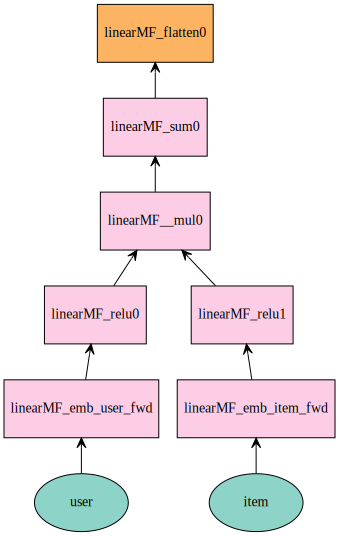

In [55]:
class LinearMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, max_user=max_user, max_item=max_item):
        super(LinearMatrixFactorization, self).__init__(prefix='linearMF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user).relu()
        items_embeddings = self.item_embedding(item).relu()
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_embeddings * items_embeddings).sum(axis=1)
        
        return pred.flatten()

net1 = LinearMatrixFactorization(64)
net1.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net1(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [56]:
net1.summary(user.as_in_context(ctx), item.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (128,), (128,)               0
         Embedding-1                                   (128, 64)           60416
         Embedding-2                                   (128, 64)          107712
LinearMatrixFactorization-3                                    (128, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 168128
   Trainable params: 168128
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 168128
--------------------------------------------------------------------------------


In [57]:
losses_1 = train(net1, train_data, test_data, epochs=15, learning_rate=1, ctx=ctx)

Epoch [0], Training RMSE 6.1865, Test RMSE 5.1936
Epoch [1], Training RMSE 2.8860, Test RMSE 2.1174
Epoch [2], Training RMSE 1.3383, Test RMSE 1.3442
Epoch [3], Training RMSE 0.9268, Test RMSE 1.0701


INFO:root:Update[3126]: Change learning rate to 2.00000e-01


Epoch [4], Training RMSE 0.7575, Test RMSE 0.9449
Epoch [5], Training RMSE 0.6737, Test RMSE 0.9268
Epoch [6], Training RMSE 0.6582, Test RMSE 0.9146
Epoch [7], Training RMSE 0.6446, Test RMSE 0.8985
Epoch [8], Training RMSE 0.6322, Test RMSE 0.8883


INFO:root:Update[6251]: Change learning rate to 4.00000e-02


Epoch [9], Training RMSE 0.6208, Test RMSE 0.8767
Epoch [10], Training RMSE 0.6098, Test RMSE 0.8747
Epoch [11], Training RMSE 0.6078, Test RMSE 0.8737
Epoch [12], Training RMSE 0.6057, Test RMSE 0.8710
Epoch [13], Training RMSE 0.6037, Test RMSE 0.8700
Epoch [14], Training RMSE 0.6018, Test RMSE 0.8676


The optimizer used for training and hyper-parameter influence greatly how fast the model converge.
We can try with the [Adam optimizer](https://arxiv.org/abs/1412.6980) which will often converge much faster than SGD without momentum as we used before.  You should see this model over-fitting quickly. 

In [58]:
net1 = LinearMatrixFactorization(64)
net1.initialize(mx.init.Xavier(), ctx=ctx)

In [59]:
losses_1_adam = train(net1, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 1.2345, Test RMSE 0.7117
Epoch [1], Training RMSE 0.6484, Test RMSE 0.6595
Epoch [2], Training RMSE 0.5852, Test RMSE 0.6638
Epoch [3], Training RMSE 0.5195, Test RMSE 0.5940


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.4531, Test RMSE 0.5907
Epoch [5], Training RMSE 0.2978, Test RMSE 0.4900
Epoch [6], Training RMSE 0.2770, Test RMSE 0.4913
Epoch [7], Training RMSE 0.2710, Test RMSE 0.4917
Epoch [8], Training RMSE 0.2654, Test RMSE 0.4953


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.2613, Test RMSE 0.4917
Epoch [10], Training RMSE 0.2311, Test RMSE 0.4868
Epoch [11], Training RMSE 0.2284, Test RMSE 0.4887
Epoch [12], Training RMSE 0.2278, Test RMSE 0.4881
Epoch [13], Training RMSE 0.2274, Test RMSE 0.4901
Epoch [14], Training RMSE 0.2272, Test RMSE 0.4910


## Estimated rating matrix

In [92]:
ratings = nd.dot(net1.user_embedding.weight.data(), net1.item_embedding.weight.data().T)
ratings.shape

(944, 1683)

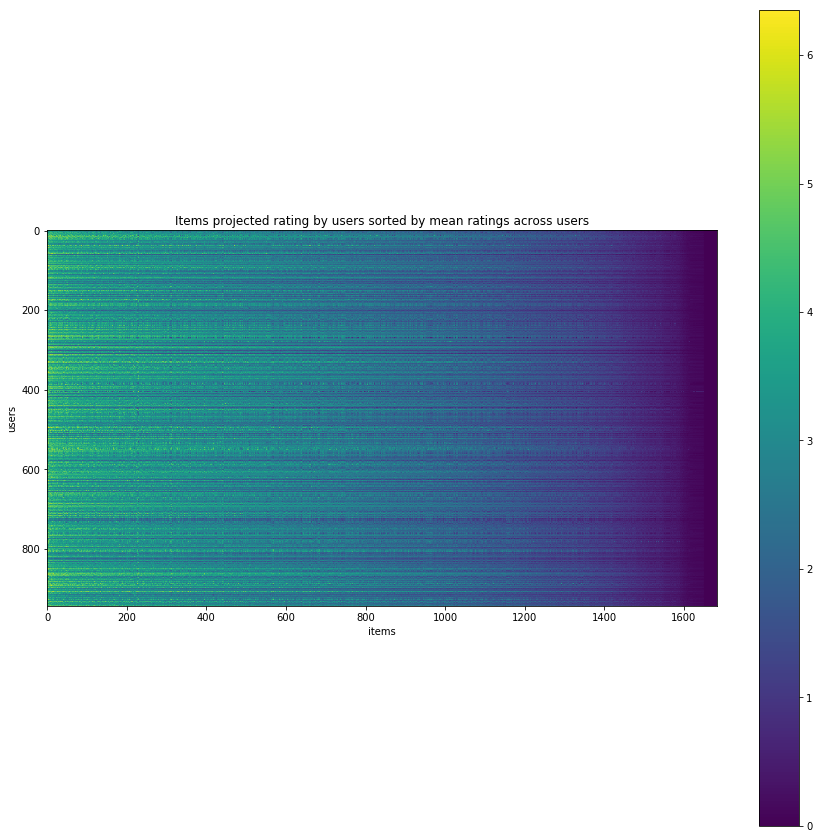

In [139]:
plt.figure(figsize=(15,15))
plt.xlabel('items')
plt.ylabel('users')
plt.title('Items projected rating by users sorted by mean ratings across users')
ax = plt.imshow(((ratings[:, ratings.asnumpy().mean(axis=0).argsort()[::-1]]).asnumpy()))
plt.colorbar(ax)

We can observe that some movies tend to be widely recommended or not recommended, whilst some other have more variance in their predicted score

In [124]:
top_5_movies = ratings.mean(axis=0).asnumpy().argsort()[::-1][:20] # Highest mean projected rating
worst_5_movies = ratings.mean(axis=0).asnumpy().argsort()[:5] # Lowest mean projected rating
top_5_controversial = ratings.asnumpy().std(axis=0).argsort()[::-1][:20] # With most variance

In [125]:
with open('ml-100k/u.item', 'rb') as f:
    movies = f.readlines()

In [126]:
print("Top 5 movies:")
for movie in top_5_movies:
    print(str(movies[int(movie)-1]).split("|")[1])
print("\nWorst 5 movies:")
for movie in worst_5_movies:
    print(str(movies[int(movie)-1]).split("|")[1])
print("\n5 most controversial movies:")
for movie in top_5_controversial:
    print(str(movies[int(movie)-1]).split("|")[1])

Top 5 movies:
Schindler's List (1993)
L.A. Confidential (1997)
Star Wars (1977)
Titanic (1997)
Shawshank Redemption, The (1994)
Good Will Hunting (1997)
Usual Suspects, The (1995)
Close Shave, A (1995)
Casablanca (1942)
Boot, Das (1981)
Wrong Trousers, The (1993)
Godfather, The (1972)
Raiders of the Lost Ark (1981)
Silence of the Lambs, The (1991)
Apt Pupil (1998)
Rear Window (1954)
As Good As It Gets (1997)
Fargo (1996)
One Flew Over the Cuckoo's Nest (1975)
North by Northwest (1959)

Worst 5 movies:
Homage (1995)
Bird of Prey (1996)
Promise, The (Versprechen, Das) (1994)
Fear, The (1995)
Window to Paris (1994)

5 most controversial movies:
Pulp Fiction (1994)
Independence Day (ID4) (1996)
Clockwork Orange, A (1971)
Big Night (1996)
Apocalypse Now (1979)
Three Colors: Blue (1993)
Godfather, The (1972)
Dead Man Walking (1995)
GoodFellas (1990)
Brazil (1985)
Chinatown (1974)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
Air Force One (1997)
Star Wars (1977)

## Neural Network (non-linear) Matrix Factorization

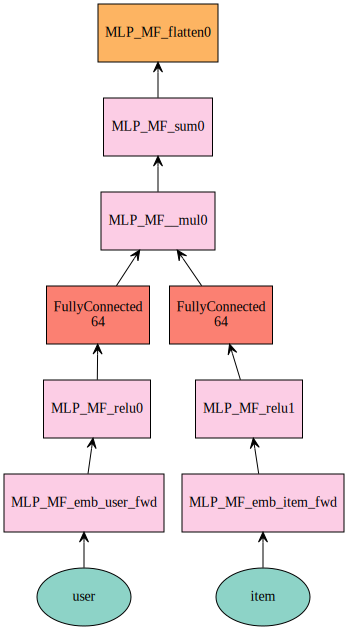

In [12]:
class MLPMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden, max_user=max_user, max_item=max_item):
        super(MLPMatrixFactorization, self).__init__(prefix='MLP_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_') 
            self.user_mlp = gluon.nn.Dense(hidden, prefix='dense_user_')

            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_') 
            self.item_mlp = gluon.nn.Dense(hidden, prefix='dense_item_')
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_embeddings_relu = user_embeddings.relu()
        user_transformed = self.user_mlp(user_embeddings_relu)
        
        items_embeddings = self.item_embedding(item)
        items_embeddings_relu = items_embeddings.relu()
        items_transformed = self.item_mlp(items_embeddings_relu)
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * items_transformed).sum(axis=1)
        
        return pred.flatten()

net2 = MLPMatrixFactorization(64, 64)
net2.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net2(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [13]:
net2.summary(user.as_in_context(ctx), item.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (128,), (128,)               0
         Embedding-1                                   (128, 64)           60416
             Dense-2                                   (128, 64)            4160
         Embedding-3                                   (128, 64)          107712
             Dense-4                                   (128, 64)            4160
MLPMatrixFactorization-5                                    (128, 1)               0
Parameters in forward computation graph, duplicate included
   Total params: 176448
   Trainable params: 176448
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 176448
--------------------------------------------------------------------------------


In [14]:
losses_2 = train(net2, train_data, test_data, epochs=15, ctx=ctx)

Epoch [0], Training RMSE 1.3169, Test RMSE 0.6554
Epoch [1], Training RMSE 0.6101, Test RMSE 0.6412
Epoch [2], Training RMSE 0.5971, Test RMSE 0.6304
Epoch [3], Training RMSE 0.5846, Test RMSE 0.6189


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.5723, Test RMSE 0.6062
Epoch [5], Training RMSE 0.5643, Test RMSE 0.6044
Epoch [6], Training RMSE 0.5617, Test RMSE 0.6023
Epoch [7], Training RMSE 0.5592, Test RMSE 0.5985
Epoch [8], Training RMSE 0.5566, Test RMSE 0.5970


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.5540, Test RMSE 0.5948
Epoch [10], Training RMSE 0.5524, Test RMSE 0.5939
Epoch [11], Training RMSE 0.5519, Test RMSE 0.5934
Epoch [12], Training RMSE 0.5514, Test RMSE 0.5932
Epoch [13], Training RMSE 0.5509, Test RMSE 0.5923
Epoch [14], Training RMSE 0.5504, Test RMSE 0.5924


We can try training with the Adam optimizer instead

In [15]:
net2 = MLPMatrixFactorization(64, 64)
net2.initialize(mx.init.Xavier(), ctx=ctx)

In [16]:
losses_2_adam  = train(net2, train_data, test_data, epochs=15, optimizer='adam', learning_rate=0.01, ctx=ctx)

Epoch [0], Training RMSE 0.6292, Test RMSE 0.4896
Epoch [1], Training RMSE 0.4623, Test RMSE 0.4803
Epoch [2], Training RMSE 0.4539, Test RMSE 0.4832
Epoch [3], Training RMSE 0.4486, Test RMSE 0.5028


INFO:root:Update[3126]: Change learning rate to 2.00000e-03


Epoch [4], Training RMSE 0.4462, Test RMSE 0.4936
Epoch [5], Training RMSE 0.4144, Test RMSE 0.4508
Epoch [6], Training RMSE 0.4054, Test RMSE 0.4500
Epoch [7], Training RMSE 0.4026, Test RMSE 0.4495
Epoch [8], Training RMSE 0.4013, Test RMSE 0.4504


INFO:root:Update[6251]: Change learning rate to 4.00000e-04


Epoch [9], Training RMSE 0.3997, Test RMSE 0.4509
Epoch [10], Training RMSE 0.3912, Test RMSE 0.4471
Epoch [11], Training RMSE 0.3898, Test RMSE 0.4470
Epoch [12], Training RMSE 0.3892, Test RMSE 0.4470
Epoch [13], Training RMSE 0.3889, Test RMSE 0.4470
Epoch [14], Training RMSE 0.3885, Test RMSE 0.4472


## Deep Neural Network (Residual Network / ResNet)
Borrowing ideas from [Deep Residual Learning for Image Recognition (He, et al.)](https://arxiv.org/abs/1512.03385) to build a complex deep network that is aggressively regularized, thanks to the dropout layers, to avoid over-fitting, but still achieves good performance. 

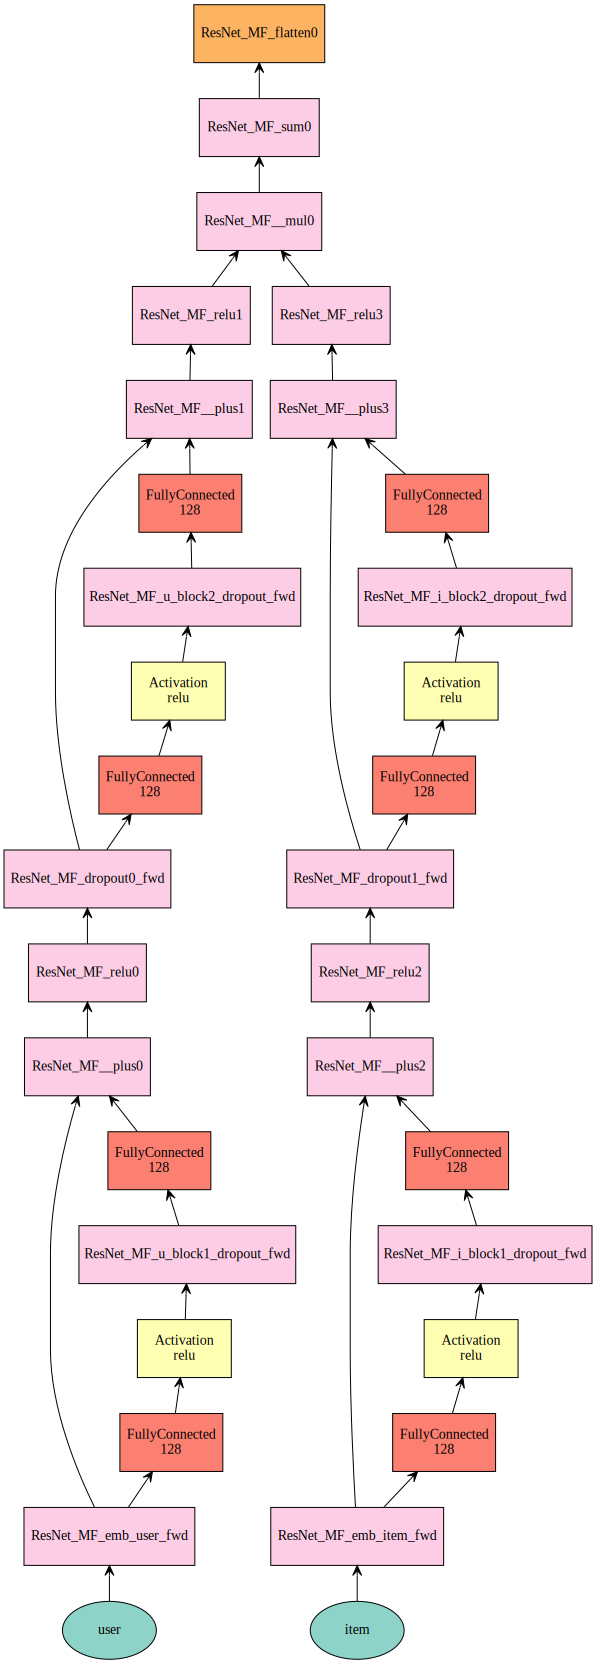

In [11]:
def get_residual_block(prefix='res_block_', hidden=64):
    block = gluon.nn.HybridSequential(prefix=prefix)
    with block.name_scope():
        block.add(
            gluon.nn.Dense(hidden, activation='relu', prefix='d1_'),
            gluon.nn.Dropout(0.5, prefix='dropout_'),
            gluon.nn.Dense(hidden, prefix='d2_')
        )
    return block
    
class ResNetMatrixFactorization(gluon.HybridBlock):
    
    def __init__(self, k, hidden, max_user=max_user, max_item=max_item):
        super(ResNetMatrixFactorization, self).__init__(prefix='ResNet_MF_')
        
        # user feature lookup
        with self.name_scope():
            self.user_embedding = gluon.nn.Embedding(input_dim=max_user, output_dim = k, prefix='emb_user_')
            self.user_block1 = get_residual_block('u_block1_', hidden)
            self.user_dropout = gluon.nn.Dropout(0.5)
            self.user_block2 = get_residual_block('u_block2_', hidden)           
            
            # item feature lookup
            self.item_embedding = gluon.nn.Embedding(input_dim=max_item, output_dim = k, prefix='emb_item_')
            self.item_block1 = get_residual_block('i_block1_', hidden)
            self.item_dropout = gluon.nn.Dropout(0.5)
            self.item_block2 = get_residual_block('i_block2_', hidden)           
            
    
    def hybrid_forward(self, F, user, item):
        user_embeddings = self.user_embedding(user)
        user_block1 = self.user_block1(user_embeddings)
        user1 = (user_embeddings + user_block1).relu()
        
        user2 = self.user_dropout(user1)
        user_block2 = self.user_block2(user2)
        user_transformed = (user2 + user_block2).relu()
        
        item_embeddings = self.item_embedding(item)
        item_block1 = self.item_block1(item_embeddings)
        item1 = (item_embeddings + item_block1).relu()
        
        item2 = self.item_dropout(item1)
        item_block2 = self.item_block2(item2)
        item_transformed = (item2 + item_block2).relu()
        
        # predict by the inner product, which is elementwise product and then sum
        pred = (user_transformed * item_transformed).sum(axis=1)
        
        return pred.flatten()

net3 = ResNetMatrixFactorization(128, 128)
net3.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net3(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [ ]:
net3.summary(user.as_in_context(ctx), item.as_in_context(ctx))

In [ ]:
losses_3  = train(net3, train_data, test_data, epochs=30, optimizer='adam', learning_rate=0.001, ctx=ctx, num_epoch_lr=10)

## Visualizing results
Now let's draw a single chart that compares the learning curves of the two different models.

In [ ]:
train_1,  test_1  = list(zip(*losses_1))
train_1a, test_1a = list(zip(*losses_1_adam))
train_2,  test_2  = list(zip(*losses_2))
train_2a, test_2a = list(zip(*losses_2_adam))
train_3a, test_3a = list(zip(*losses_3))

In [ ]:
plt.figure(figsize=(20,20))
h1, = plt.plot(range(15), test_1, 'c', label='test loss Linear')
h2, = plt.plot(range(15), train_1, 'c--', label='train loss Linear')
h3, = plt.plot(range(15), test_1a, 'b', label='test loss Linear Adam')
h4, = plt.plot(range(15), train_1a, 'b--', label='train loss Linear Adam')
h5, = plt.plot(range(15), test_2, 'r', label='test loss MLP')
h6, = plt.plot(range(15), train_2, 'r--', label='train loss MLP')
h7, = plt.plot(range(15), test_2a, 'm', label='test loss MLP Adam')
h8, = plt.plot(range(15), train_2a, 'm--', label='train loss MLP Adam')
h9, = plt.plot(range(30), test_3a, 'g', label='test loss ResNet Adam')
h10, = plt.plot(range(30), train_3a, 'g--', label='train loss ResNet Adam')
l   = plt.legend(handles=[h1, h2, h3, h4, h5, h6, h7, h8, h9, h10])

## Acknowledgement

This tutorial is based on examples from [xlvector/github](https://github.com/xlvector/).

## Next steps
See [this notebook](demo1-MF2-fancy.ipynb) to try using fancier network structures and optimizers on this same problem.